<a href="https://colab.research.google.com/github/sidharth0909/ML-DL/blob/main/Exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:25<00:00, 122MB/s]
100% 2.29G/2.29G [00:25<00:00, 96.2MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('//content/chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [22]:
import os
import cv2
import keras
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout

In [13]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 128

def loading_training_data(data_dir):
    data = []
    labels_list = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append(resized_arr)
            labels_list.append(class_num)

    return np.array(data), np.array(labels_list)

train_data, train_labels = loading_training_data('/content/chest_xray/train')
test_data, test_labels = loading_training_data('/content/chest_xray/test')

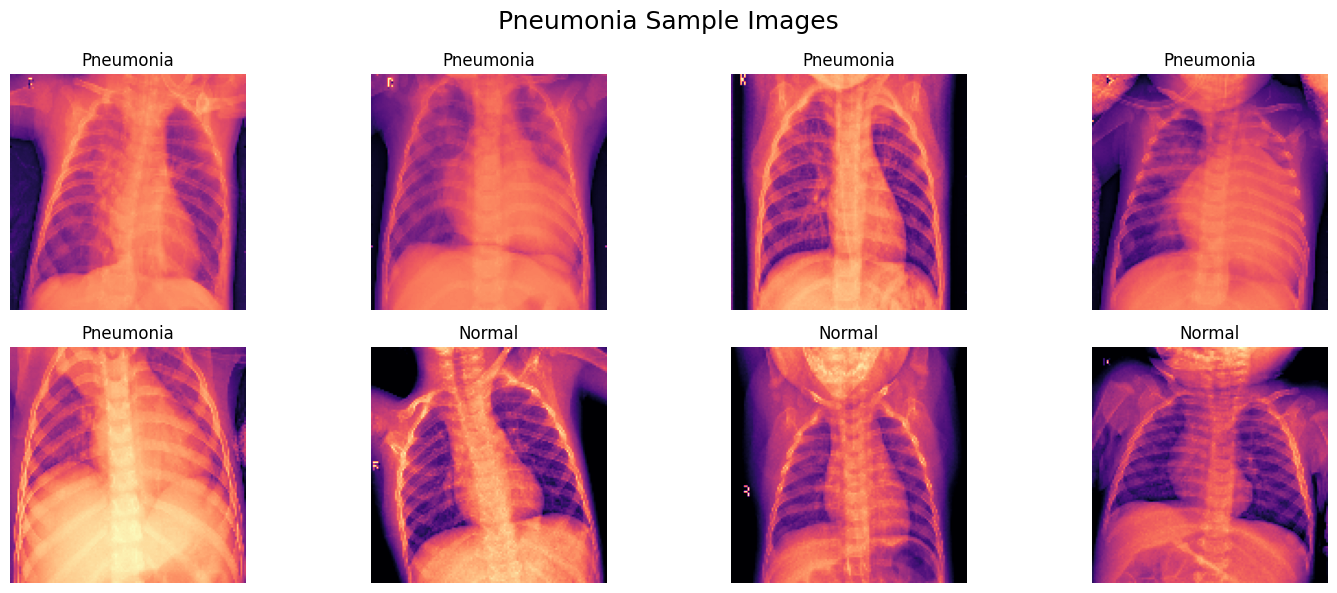

In [14]:
random_indices = np.random.choice(len(train_data), 8, replace=False)
plt.figure(figsize=(15, 6))

for i, idx in enumerate(random_indices):
    plt.subplot(2, 4, i + 1)
    plt.imshow(train_data[idx], cmap='magma')
    plt.title('Pneumonia' if train_labels[idx] == 0 else 'Normal')
    plt.axis('off')

plt.suptitle("Pneumonia Sample Images", size=18)
plt.tight_layout()
plt.show()

<ipython-input-15-58200d189e9f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = labels_df, x='Labels', palette=[colors[3], colors[6]])


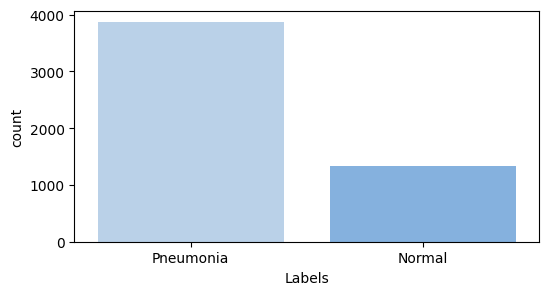

In [15]:
# Training Data Distribution
labels_df = pd.DataFrame({"Labels":train_labels})

plt.figure(figsize=(6,3))
colors = sns.light_palette("#76B1ED", n_colors=7)
sns.countplot(data = labels_df, x='Labels', palette=[colors[3], colors[6]])
plt.xticks(ticks=[0, 1], labels=['Pneumonia', 'Normal'])
plt.show()

In [16]:
# Normalize the data
X_train = np.array(train_data) / 255
X_test = np.array(test_data) / 255

In [17]:
import numpy as np

img_size = 128

# Reshape the grayscale images to 128x128x1
X_train = X_train.reshape(-1, img_size, img_size, 1)
X_test = X_test.reshape(-1, img_size, img_size, 1)

# Convert grayscale to RGB by duplicating the single channel 3 times
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Convert labels to numpy arrays
y_train = np.array(train_labels)
y_test = np.array(test_labels)

print(X_train.shape)  # This should now show (num_samples, 128, 128, 3)
print(X_test.shape)

(5216, 128, 128, 3)
(624, 128, 128, 3)


In [18]:
# Set the validation size
val_size = 0.2

# Split the data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=val_size, random_state=21)

# Check the shapes
print("Training data shape:", X_train_split.shape)
print("Validation data shape:", X_val_split.shape)
print("Training labels shape:", y_train_split.shape)
print("Validation labels shape:", y_val_split.shape)

Training data shape: (4172, 128, 128, 3)
Validation data shape: (1044, 128, 128, 3)
Training labels shape: (4172,)
Validation labels shape: (1044,)


In [24]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
datagen_train = ImageDataGenerator(rescale=1./255)  # Only rescale for training data
datagen_validation = ImageDataGenerator(rescale=1./255)  # Rescale for validation data
datagen_test = ImageDataGenerator(rescale=1./255)  # Rescale for test data

In [35]:
# Training data generator
train_generator = datagen_train.flow_from_directory(
    '/content/chest_xray/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.


In [36]:
# Validation data generator
validation_generator = datagen_validation.flow_from_directory(
    '/content/chest_xray/val',  # Pointing to validation directory
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 16 images belonging to 2 classes.


In [37]:
test_generator = datagen_test.flow_from_directory(
    '/content/chest_xray/test',  # Pointing to test directory
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 624 images belonging to 2 classes.


In [38]:
from tensorflow.keras.callbacks import EarlyStopping
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [39]:
model.fit(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8277 - loss: 1.8037 - val_accuracy: 0.8750 - val_loss: 0.1907
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9782 - loss: 0.0639 - val_accuracy: 0.8750 - val_loss: 0.2814
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.9941 - loss: 0.0275 - val_accuracy: 0.8750 - val_loss: 0.1334
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.9944 - loss: 0.0198 - val_accuracy: 0.8750 - val_loss: 0.2508
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.9991 - loss: 0.0068 - val_accuracy: 0.8750 - val_loss: 0.1739
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.9998 - loss: 0.0041 - val_accuracy: 0.8750 - val_loss: 0.2674
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8750 - val_loss: 0.3134
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 1.0000 - loss: 9.0725e-04 - val_accuracy: 0

In [40]:
# Save the trained model
model.save('diagnostic_model.h5')

In [41]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.2f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 474ms/step - accuracy: 0.7406 - loss: 2.2156
Test accuracy: 0.73


In [42]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('diagnostic_model.h5')



In [48]:
# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Resize to match model input
    img_array = image.img_to_array(img)  # Convert to array
    img_array = img_array / 255.0  # Rescale pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# List of test images
test_image_paths = [
    '/content/chest_xray/train/NORMAL/IM-0119-0001.jpeg',
    '/content/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg',
    '/content/chest_xray/test/PNEUMONIA/person101_bacteria_483.jpeg',
]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


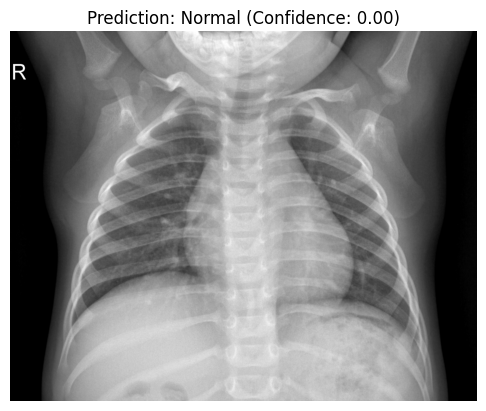

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


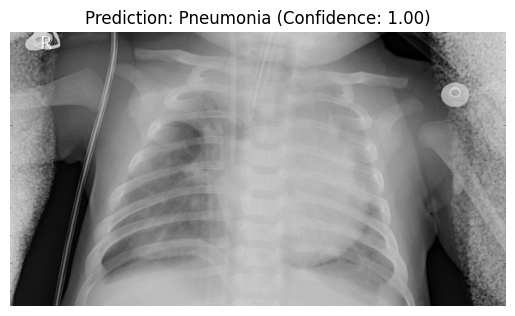

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


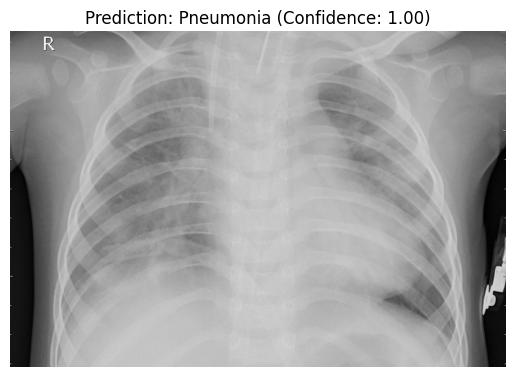

In [49]:

# Predict and display results
for img_path in test_image_paths:
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)

    # Assuming a binary classification (0 or 1)
    predicted_class = 'Pneumonia' if prediction[0][0] > 0.5 else 'Normal'

    # Display the image and prediction
    plt.imshow(image.load_img(img_path))  # Load the original image for display
    plt.title(f'Prediction: {predicted_class} (Confidence: {prediction[0][0]:.2f})')
    plt.axis('off')
    plt.show()